# Imports and defs

In [212]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder, TargetEncoder
from sklearn.impute import KNNImputer
from typing import Callable
import plotly
import plotly.express as px
import plotly.graph_objects as go

In [4]:
DTYPES = {'datesold': }

In [196]:
### General utils



In [337]:
### Plotting helper functions

def calc_nrows_from_ncols(nplots: int, ncols: int = 3, nrows: int | None = None) -> int:
    """
    Calculate how many rows are needed in a subplot, given nplots and desired ncols.
    If nrows is given, function just returns nrows.
    """
    assert nplots>0 and ncols>0, f"nplots and ncols must be a positive integers. Values are nplots={nplots}, ncols={ncols}"
    nrows = int(np.ceil(nplots/ncols)) if nrows is None else nrows
    return nrows

def create_subplots(nplots: int, nrows: int, ncols: int, figsize: tuple[int, int] | None = None) -> tuple[plt.Figure, np.ndarray[plt.Axes]]:
    """
    Some boiler plate code for plotting multiple EDA plots
    """
    assert nplots>0 and ncols>0, f"nplots and ncols must be a positive integers. Values are nplots={nplots}, ncols={ncols}"
    nrows = calc_nrows_from_ncols(nplots=nplots, ncols=ncols, nrows=nrows)
    assert nrows>0, f"nrows must all be a positive integers. nrows={nrows}"
    figsize = (3 * ncols, 3 * nrows) if figsize is None else figsize
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axs_1d = axs.reshape(-1) # easier view
    for i in range(nplots, ncols*nrows):
        axs_1d[i].set_axis_off()
    
    return fig, axs
    
def plot_cat_counts(
    df: pd.DataFrame, 
    cat_cols: list[str], 
    ncols: int = 3,
    nrows: int | None = None, 
    figsize: tuple[int, int] | None = None
    ) -> tuple[plt.Figure, np.ndarray]:
    """
    Plot the value-counts of categorical columns in df using a bar plot.
    """
    nrows = calc_nrows_from_ncols(nplots=len(cat_cols), ncols=ncols, nrows=nrows)
    figsize = (3 * ncols, 3 * nrows) if figsize is None else figsize
    fig, axs = create_subplots(nplots=len(cat_cols), nrows=nrows, ncols=ncols, figsize=figsize)
    axs_1d = axs.reshape(-1) # easier view
    for i, cat_col in enumerate(cat_cols):
        df[cat_col].value_counts().sort_index().plot.bar(ax=axs_1d.reshape(-1)[i])
        axs_1d[i].set_title(cat_col)
        axs_1d[i].set_xlabel('')
    plt.tight_layout()
    return fig, axs

def plot_boxplots(
    df: pd.DataFrame, 
    boxplot_cols: list[str], 
    ncols: int = 3, 
    nrows: int | None = None,
    figsize: tuple[int, int] | None = None
    ) -> tuple[plt.Figure, np.ndarray]:
    """
    Plot the boxplots for boxplot_cols
    #TODO: Very similar code to plot_cat_counts, share code.
    """
    fig, axs = create_subplots(nplots=len(boxplot_cols), nrows=nrows, ncols=ncols, figsize=figsize)
    axs_1d = axs.reshape(-1) # easier view
    for i, boxplot_col in enumerate(boxplot_cols):
        df[boxplot_col].plot(ax=axs_1d.reshape(-1)[i], kind='box')
        axs_1d[i].set_title(boxplot_col)
        axs_1d[i].set_xlabel('')
    plt.tight_layout()
    return fig, axs


def plot_temporal_distribution(dates: pd.Series, freq: str) -> tuple[plt.Figure, plt.Axes]:
    """
    Plots the number of observations distirbution per frequency (month, quarter, year, etc.).
    freq may be any of the frequencies allowed by pd's to_period(freq).
    """
    fig, ax = plt.subplots()
    dates.dt.to_period(freq=freq).dt.start_time.dt.date.value_counts().sort_index().plot.bar(ax=ax)
    ax.set_xlabel(FREQ_SHORT_TO_FULL.get(freq, freq))
    return fig, ax

# def plot_temporal_distribution(dates: pd.Series, freq: str) -> tuple[plt.Figure, plt.Axes]:
#     """
#     Plots the number of observations distirbution per frequency (month, quarter, year, etc.).
#     freq may be any of the frequencies allowed by pd's to_period(freq).
#     """
#     fig, ax = plt.subplots()
#     counts_per_period = dates.dt.to_period(freq=freq).value_counts().sort_index()
#     counts_per_period_full = add_missing_periods(counts_per_period, freq).fillna(0)
#     x = counts_per_period_full.index.dt.start_time.dt.date
#     y = counts_per_period_full.values
#     plt.plot.bar(x=x, y=y, ax=ax)
#     ax.set_xlabel(FREQ_SHORT_TO_FULL.get(freq, freq))
#     return fig, ax
    
def plot_scatter_matrix(
    df: pd.DataFrame, 
    include_cols: list[str] | None = None, 
    exclude_cols: list[str] | None = None, 
    # figsize: tuple[int, int] | None = None,
    alpha: float = 0.1,
) -> np.ndarray:
    include_cols = df.columns if include_cols is None else include_cols
    exclude_cols = [] if exclude_cols is None else exclude_cols
    # ncols = len(include_cols) - len(exclude_cols)
    # figsize = (ncols, ncols) if figsize is None else figsize
    # axs = pd.plotting.scatter_matrix(df[include_cols].drop(columns=exclude_cols), figsize=figsize, alpha=alpha)
    axs = sns.pairplot(df[include_cols].drop(columns=exclude_cols), plot_kws={'alpha': alpha})
    plt.tight_layout()
    return axs

In [ ]:
### Outlier detecion

def assert_numerical(df: pd.DataFrame) -> None:
    """
    Assert that all columns in df are numerical
    """
    if df.select_dtypes(exclude = 'number').size != 0:
        raise(ValueError("df must contain numerical values only"))
        
def get_max_zscore(df: pd.DataFrame) -> pd.Series:
    """
    Get maximal absolute zscore per column in df.
    """
    assert_numerical(df)
    zscored = df.apply(lambda s: zscore(s.dropna()))
    return zscored.abs().max() 

def sort_cols_by_max_zscore(df):
    max_abs_zscore = get_max_zscore(df)
    sorted_cols = np.argsort(-max_abs_zscore)
    return df.iloc[:,sorted_cols]

def get_cols_w_outliers(df, outlier_zscore: float = 4, exclude: list[str] = None):
    max_abs_zscore = get_max_zscore(df.drop(columns=exclude))
    outlier_cols = max_abs_zscore[lambda s: s>outlier_zscore].index
    return df[outlier_cols]

### Missing values imputation

def impute_cols(
    df: pd.DataFrame,
    impute_col: str,
    values_col: str,
    groupby_cols: list[str] | pd.Index | None = None,
):
    """
    Impute missing values in impute_col by the mean of values_col. If groupby_cols is not empty, returns the mean per group.
    """
    if groupby_cols is not None and len(groupby_cols)>0:
        return df[impute_col].fillna(df.groupby(groupby_cols)[values_col].transform('mean'))
    else:
        return df[impute_col].fillna(df[values_col].mean())

def impute_by_group_mean(df: pd.DataFrame,
                        impute_col_by_groupby: dict,
                        inplace: bool = False,
                        ) -> pd.DataFrame:
    """
    Imputes columns defined in impute_col_by_groupby's keys, according to the dictionary defined in their values.
    #TODO: Lose redundant functionality allowing calculating the mean from a different col from the one that's being imputed. i.e. dict should only be {'col1': ['col2', 'col3']}
    Input:
     - impute_col_by_groupby: dict who's keys are columns to impute and values are dictionaries with the target column from which to calc the mean, and columns to group by when calculating mean.
    Example:
        impute_col_by_groupby = {
        'col1': {
            VALUES_COL_KEY: 'col1',
            GROUPBY_COL_KEY: ['col2', 'col3'],
            },
        }
        then col1 will be imputed by the mean of df.groupby([col2,col3])[col1]
    """
    if not inplace:
        df = df.copy()
    for impute_col, impute_by in impute_col_by_groupby.items():
        df[impute_col] = impute_cols(df, impute_col, impute_by[VALUES_COL_KEY], impute_by[GROUPBY_COL_KEY])
    if not inplace:
        return df

In [ ]:
### Encodings

def one_hot_encode(
    df: pd.DataFrame, 
    col_encoding: dict, 
    original_cols_to_keep: list[str] | pd.Index | None = None,
) -> pd.DataFrame:
    """
    Encodes the columns in col_encoding's keys, and passes the kwargs in their values to pd.get_dummies()
    If original_cols_to_keep is None, keeps all original encoded cols.
    Returns the whole df, with the encoded columns
    #TODO: More detailed docstring
    """
    cols_to_encode = list(col_encoding.keys())
    original_cols_to_keep = original_cols_to_keep if original_cols_to_keep is not None else cols_to_encode
    bad_cols_to_keep = set(original_cols_to_keep) - set(cols_to_encode)
    assert len(bad_cols_to_keep)==0, f"original_cols_to_keep must be a subset of col_encoding's keys. Additional cols are: {bad_cols_to_keep}"
    none_encoded_cols = df.columns.difference(col_encoding.keys())
    encodings = pd.concat([pd.get_dummies(df[column], **args) for column, args in col_encoding.items()], axis=1)
    return pd.concat([df[none_encoded_cols], df[original_cols_to_keep], encodings], axis=1)

def label_encode(
    df: pd.DataFrame,
    col_encoding: dict,
    encoded_postfix : str = LABEL_ENCODED_POSTFIX,
    inplace: bool = False,
):
    """
    Ignores missing values.
    """
    df = copy_if_not_inplace(df, inplace)
    label_encoder = LabelEncoder()
    for column, categories in col_encoding.items():
        label_encoder.fit(categories)
        missing = df[column].isna()
        if sum(missing) > 0:
            print(f'{missing.sum()} missing values in {column} are not label encoded.')
        df.loc[~missing, f'{column}{encoded_postfix}'] = label_encoder.transform(df.loc[~missing, column])
    return df

def target_endode(
    df: pd.DataFrame,
    col_encodings: dict,
    encoded_postfix : str = TARGET_ENCODED_POSTFIX,
    inplace: bool = False,
) -> pd.DataFrame:
    """
    Encodes the categories in col_encodings according to a predefined mapping.
    Each column in col_encodings keys is encoded using the mappings defined in its values.
    E.g. col_encodings = dict(Embarked={'C': 0, 'Q': 1, 'S': 1}). Mappings should be valid input to pd.Series.map()
    """
    df = copy_if_not_inplace(df, inplace)    
    for cat_col, encoding in col_encodings.items():
        df[f'{cat_col}{encoded_postfix}'] = df[cat_col].map(encoding)
    return df
    
def target_encode_train(
    df: pd.DataFrame,
    target: str | pd.Series,
    col_encoding_aggs: dict,
    encoded_postfix : str = TARGET_ENCODED_POSTFIX,
    inplace: bool = False,
) -> tuple[pd.DataFrame, dict]:
    """
    Encodes the categories in columns defined in col_encoding_aggs according to aggregates calculated from target. 
    Also returns the mappings to be used on test set where target is not accessible for prediction.
    Target is either column name in df or a series (in case x,y are already seperated).
    col_encoding_aggs is a dict with column names to encode as keys and the type of aggregation to apply to target_col as values,
    e.g.
    col_encoding_aggs = dict(Embarked=pd.Series.mode)
    """
    df = copy_if_not_inplace(df, inplace)
    col_encodings = dict()
    if type(target) is str:
        target = df[target]
    for cat_col, agg in col_encoding_aggs.items():
        encoding = target.groupby(df[cat_col]).agg(agg)
        col_encodings[cat_col] = encoding
        
    df = target_endode(df, col_encodings, encoded_postfix, inplace)
    
    return df, col_encodings

In [315]:
### Temporal trends

agg_col = 'price'
date_col = 'datesold'
freq = 'M'

def _convert_to_period_if_needed(
    df: pd.DataFrame,
    date_col: str,
    freq: str | pd.PeriodDtype | None = None
) -> tuple[pd.DataFrame, str]:
    """
    Check that either date_col's dtype is period, or freq is not None (but not both).
    Returns:
        - df with the date_col as period.
        - freq - input freq if not None, otherwise date_col's period frequency.
    """
    assert isinstance(df[date_col].dtype, pd.PeriodDtype) != (freq is not None), "Either values of date_col must be period, xor freq must be given." # xor
    if freq is not None:
        df = df.copy()
        df[date_col] = df[date_col].dt.to_period(freq)
    else:
        freq = df[date_col].iloc[0].freqstr # Surely there is a nicer way, haven't fount it though
    return df, freq
    
def add_missing_periods(
    period_indexed_df: pd.DataFrame,
    freq: str,
):
    """
    Given a df with period index, makes sure it has all the periodes from the earliest to the latest, given frequency.
    """
    period_indexed_df = period_indexed_df.sort_index()
    all_periods = pd.period_range(period_indexed_df.index[0], period_indexed_df.index[-1], freq=freq)
    return pd.DataFrame(index = all_periods).merge(period_indexed_df, left_index=True, right_index=True, how='left')

def agg_over_time(
    df: pd.DataFrame,
    agg_col: str,
    date_col: str,
    freq: str | None = None,
    agg_func: str | Callable[pd.Series, int] = 'mean',
    is_add_missing_periods: bool = True,
) -> pd.Series:
    """
    Aggregates df[agg_col] using agg_func per date_col. date_col's dtype must be period, or freq is not None (but not both).
    If freq is not None, first converts date_col to period.
    If is_add_missing_periods, adds missing time periods with NaNs according to freq (which when None is calculated from date_col).
    """
    df, freq = _convert_to_period_if_needed(df=df, date_col=date_col, freq=freq)
    agged = df.groupby(date_col)[agg_col].agg(agg_func)
    if is_add_missing_periods:
        agged = add_missing_periods(agged, freq)
        # all_periods = pd.period_range(agged.index[0], agged.index[-1], freq=freq)
        # agged = pd.DataFrame(index = all_periods).merge(agged, left_index=True, right_index=True, how='left')
    return agged.iloc[:,0]
    

def agg_multiple_cols_over_time(
    df: pd.DataFrame,
    date_col: str,
    agg_cols: list[str],
    freq: str | None = None,
    agg_func: str | Callable[pd.Series, int] = 'mean',
) -> plt.Axes:
    """
    Applies agg_over_time on multiple columns and concatenates into a DF.
    """
    aggs = pd.concat([
        agg_over_time(df, agg_col=agg_col, date_col=date_col, freq=freq, agg_func=agg_func)
        for agg_col in agg_cols
    ], axis=1)
    return aggs
    

def get_nans_per_period(
    df: pd.DataFrame, 
    date_col: str,
    columns: list[str] | pd.Index | None = None, 
    freq: str | None = None,
   ) -> pd.DataFrame:
    """
    Calculates the NaN rate per period defined by date_col. date_col's dtype must be period, or freq is not None (but not both).
    If freq is not None, first converts date_col to period.
    if Columns is None, calculates for all columns but date_col.
    """
    df, freq = _convert_to_period_if_needed(df=df, date_col=date_col, freq=freq)
    columns = columns if columns is not None else df.columns.difference([date_col])
    return agg_multiple_cols_over_time(
        df=df,
        date_col=date_col,
        freq=None, # date_col converter outside of loop so freq = None
        agg_cols=columns,
        agg_func=lambda s: s.isna().mean(),
    )


def agg_over_time_per_group(
    df: pd.DataFrame,
    date_col: str,
    agg_col: str,
    groupby_cols: str | list[str],
    freq: str | None = None,
    agg_func: str | Callable[pd.Series, int] = 'mean',
) -> pd.DataFrame:
    """
    Aggregates agg_col over time periods defined by date_col and per groups in groupby_col, and returns the time series per period.
    date_col's dtype must be period, or freq is not None (but not both).
    If freq is not None, first converts date_col to period.
    """
    df, freq = _convert_to_period_if_needed(df=df, date_col=date_col, freq=freq)
    aggregations = [
        agg_over_time(
        df=group_df,
        agg_col=agg_col,
        date_col=date_col,
        freq=None, # date_col converter outside of loop so freq = None
        agg_func=agg_func,
    ).rename(name) for name, group_df in df.groupby(groupby_cols)
    ]
    return pd.concat(aggregations, axis=1)
    

def disp_nans_over_time(
    df: pd.DataFrame, 
    date_col: str,
    columns: list[str] | pd.Index | None = None, 
    freq: str | None = None,
    axis: int | None = 0,
   ) -> pd.io.formats.style.Styler:
    """
    Aggregates the NaN rate per period per column in columns. 
    Return a Styler object in which columns are sorted by max NaN rate.
    """
    agged = get_nans_per_period(df, date_col=date_col, columns=columns, freq=freq)
    sorted_cols = agged.max().sort_values(ascending = False).index
    return agged[sorted_cols].style.background_gradient(axis=axis)

def plot_trends(
    df: pd.DataFrame,
    date_col: str,
    trend_cols: str | list[str],
    freq: str | None = None,
    agg_func: str | Callable[pd.Series, int] = 'mean',
    ax: plt.Axes | None = None,
    figsize: tuple[int, int] | None = None,
) -> plt.Axes:
    """
    Plots the trends of trend_cols over time, aggregated per freq using agg_func
    """
    _, ax = (None, ax) if ax is not None else plt.subplots(figsize=figsize)
    trend_cols = make_list_if_single_item(trend_cols)
    trends = agg_multiple_cols_over_time(
        df=df,
        date_col=date_col,
        agg_cols=trend_cols,
        freq=freq,
        agg_func=agg_func,
    )
    
    ax = trends.plot(ax=ax)
    return ax

In [252]:
 
# def plotly_scatter(
#     df: pd.DataFrame,
#     index: pd.Series | pd.Index,
#     mode: str = 'lines',
# ) -> plotly.graph_objs._figure.Figure:
#     """
#     Plots all columns of df as plotly scatter against index.
#     """
#     # colors = px.colors.qualitative.Plotly
#     fig = go.Figure()
#     for i, col in enumerate(df):
#         if type(col) is str:
#             # fig.add_traces(go.Scatter(x=index, y=df[col], mode=mode, line=dict(color=colors[i])))
#             fig.add_traces(go.Scatter(x=index, y=df[col], mode=mode))
#         else:
#             print()
#             fig.add_traces(go.Scatter(x=index, y=df[*col], mode=mode))
#     fig.show()
#     return fig


# # plot_trends(df, 'datesold', 'price', 'M')
# agged = agg_over_time_per_group(
#     df=df,
#     date_col='datesold',
#     agg_col='price',
#     groupby_cols=['propertyType','bedrooms'],
#     freq='M',
#     agg_func = 'mean',
# )

# # plotly_scatter(agged, index=pd.Index(data=range(len(agged))))
# # for i, col in enumerate(agged.columns):
# #     print(agged[*col])
# #     break

RangeIndex(start=0, stop=150, step=1)

# Load data

Trying on few data sets: titanic for general eda. House sales for time-related. Pedals for classes.

### Titanic

In [5]:
# filename = 'EDA_example_titanic.csv'
# df = pd.read_csv(filename)
# print(df.shape)
# df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### House sales

In [15]:
filename = 'EDA_example_house_sales.csv'
df = pd.read_csv(filename, parse_dates=['datesold'])
print(df.shape)
df.head()

(29580, 5)


,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07,2607,525000,house,4
1,2007-02-27,2906,290000,house,3
2,2007-03-07,2905,328000,house,3
3,2007-03-09,2905,380000,house,4
4,2007-03-21,2906,310000,house,3


# Explore

## Info

In [6]:
### Titanic
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [16]:
### House sales
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29580 entries, 0 to 29579
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   datesold      29580 non-null  datetime64[ns]
 1   postcode      29580 non-null  int64         
 2   price         29580 non-null  int64         
 3   propertyType  29580 non-null  object        
 4   bedrooms      29580 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.1+ MB


## Distributions

### Numerical

In [7]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
ORDINAL_CAT_COLS = ['Pclass','Parch']
# ORDINAL_CAT_COLS = []

### str/categorical

In [9]:
df.select_dtypes(include=['object','category']).describe()

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [10]:
STR_CAT_COLS = ['Sex'] # To be one-hot encoded
STR_ORDINAL_COLS = ['Embarked'] # To be label encoded
# STR_CAT_COLS = []

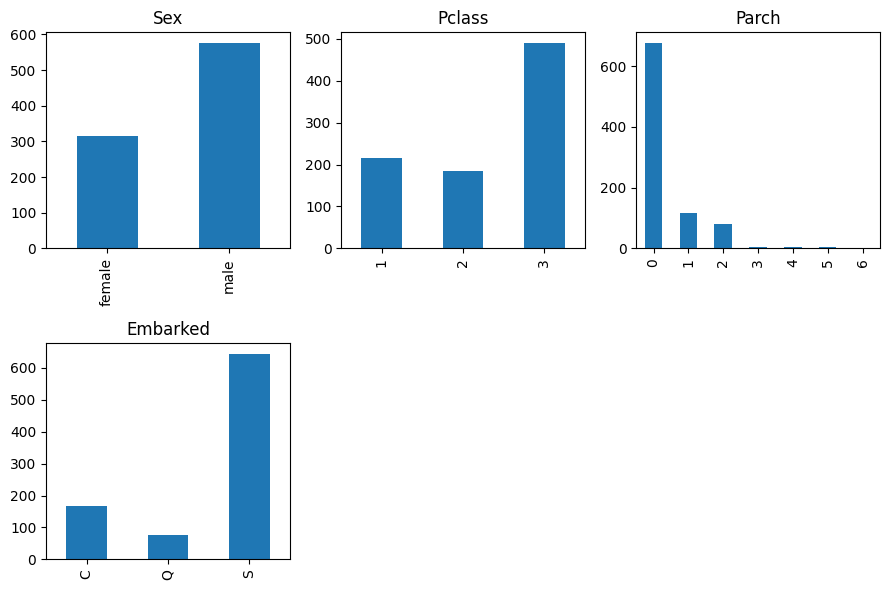

In [11]:
CAT_COLS = STR_CAT_COLS + ORDINAL_CAT_COLS + STR_ORDINAL_COLS
fig, axs = plot_cat_counts(df, CAT_COLS)

#### Understand str ordinal hierarchy

In [12]:
df.groupby('Embarked').Fare.agg(['median','mean', pd.Series.mode, 'min', 'max'])

,median,mean,mode,min,max
Embarked,,,,,
C,29.70,59.954144,7.2292,4.0125,512.3292
Q,7.75,13.276030,7.7500,6.7500,90.0000
S,13.00,27.079812,8.0500,0.0000,263.0000


In [13]:
STR_ORDINAL_COLS_ORDERED = {
    'Embarked': ['Q', 'S', 'C'],
}

### date-time

In [14]:
df.select_dtypes(include='datetime')

""
0
1
2
3
4
...
886
887
888
889


In [321]:
dates = pd.to_datetime(pd.Series([
  '2021-01-01',  
  '2021-01-02',  
  '2021-01-08',  
  '2021-02-01',  
  '2021-03-01',  
  '2021-06-01',  
  '2021-8-01',  
  '2022-01-01',  
  '2023-01-01',
]))

[5. 1. 1. 0. 1. 0. 0. 0. 1.]


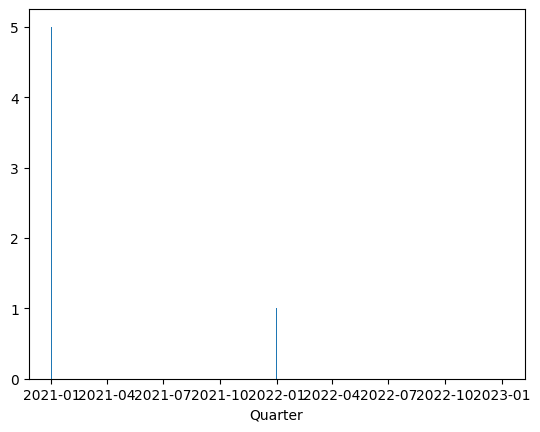

In [391]:
def _get_period_start_times_from_series(
    s: pd.Series,
) -> pd.Series:
    return s.dt.start_time.dt.date
    
def _get_period_start_times_from_period_index(
    ind: pd.PeriodIndex,
) -> pd.Series:
    return _get_period_start_times_from_series(ind.to_series())

# def plot_temporal_distribution(dates: pd.Series, freq: str) -> tuple[plt.Figure, plt.Axes]:
#     """
#     Plots the number of observations distirbution per frequency (month, quarter, year, etc.).
#     freq may be any of the frequencies allowed by pd's to_period(freq).
#     """
#     fig, ax = plt.subplots()
#     dates.dt.to_period(freq=freq).dt.start_time.dt.date.value_counts().sort_index().plot.bar(ax=ax)
#     ax.set_xlabel(FREQ_SHORT_TO_FULL.get(freq, freq))
#     return fig, ax

def plot_temporal_distribution(dates: pd.Series, freq: str) -> tuple[plt.Figure, plt.Axes]:
    """
    Plots the number of observations distirbution per frequency (month, quarter, year, etc.).
    freq may be any of the frequencies allowed by pd's to_period(freq).
    """
    fig, ax = plt.subplots()
    counts_per_period = dates.dt.to_period(freq=freq).value_counts().sort_index()
    counts_per_period_full = add_missing_periods(counts_per_period, freq).fillna(0)
    x = _get_period_start_times_from_period_index(counts_per_period_full.index).values
    y = counts_per_period_full.values.flatten()
    print(y)
    ax.bar(x, y)
    ax.set_xlabel(FREQ_SHORT_TO_FULL.get(freq, freq))
    return fig, ax

fig, ax = plot_temporal_distribution(dates, freq='Q')

In [375]:
counts_per_period = dates.dt.to_period(freq=freq).value_counts().sort_index()
counts_per_period_full = add_missing_periods(counts_per_period, freq).fillna(0)
    
get_period_start_times_from_period_index(counts_per_period_full.index)
# get_period_start_times_from_series(dates.dt.to_period(freq))

2021    2021-01-01
2022    2022-01-01
2023    2023-01-01
Freq: Y-DEC, dtype: object

AttributeError: 'PeriodIndex' object has no attribute 'dt'

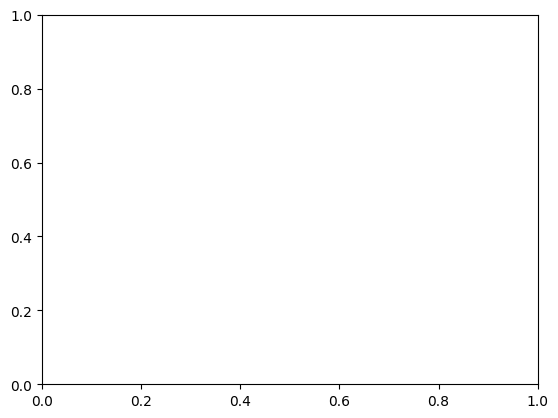

In [322]:
fig, ax = plot_temporal_distribution(dates, freq='Q')

### Other

In [17]:
df.select_dtypes(exclude=['object','number','datetime'])

""
0
1
2
3
4
...
886
887
888
889


## NaNs

In [18]:
df.isna().mean().sort_values(ascending = False)

Cabin          0.771044
Age            0.198653
Embarked       0.002245
PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
dtype: float64

## Outliers

In [19]:
cols_w_outliers = get_cols_w_outliers(df.select_dtypes(include = 'number'),exclude=ORDINAL_CAT_COLS).pipe(sort_cols_by_max_zscore)
cols_w_outliers

,Fare,SibSp
0,7.2500,1
1,71.2833,1
2,7.9250,0
3,53.1000,1
4,8.0500,0
...,...,...
886,13.0000,0
887,30.0000,0
888,23.4500,1
889,30.0000,0


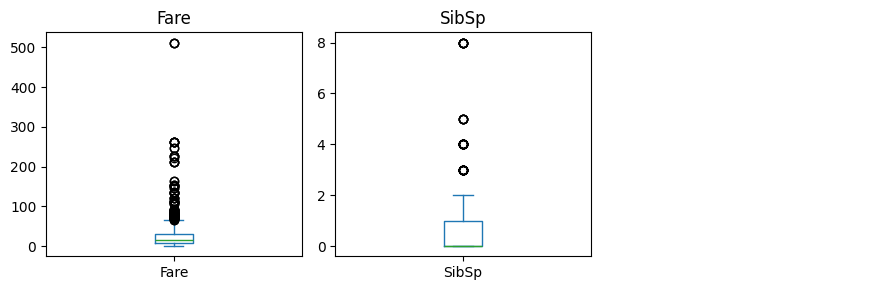

In [20]:
plot_boxplots(df, cols_w_outliers.columns);

## Multivariable relationships

### Correlations

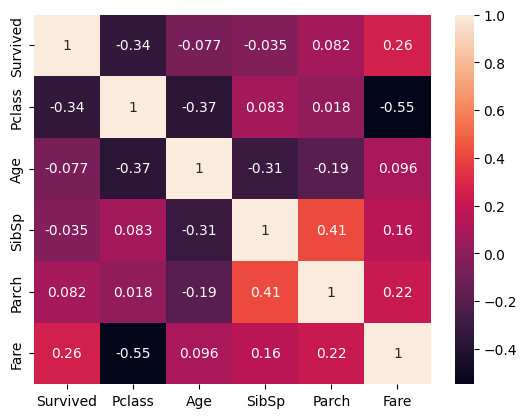

In [21]:
corr = df.select_dtypes(include='number').drop(columns=["PassengerId"]).corr()
sns.heatmap(corr, annot=True);

### Scatter matrix

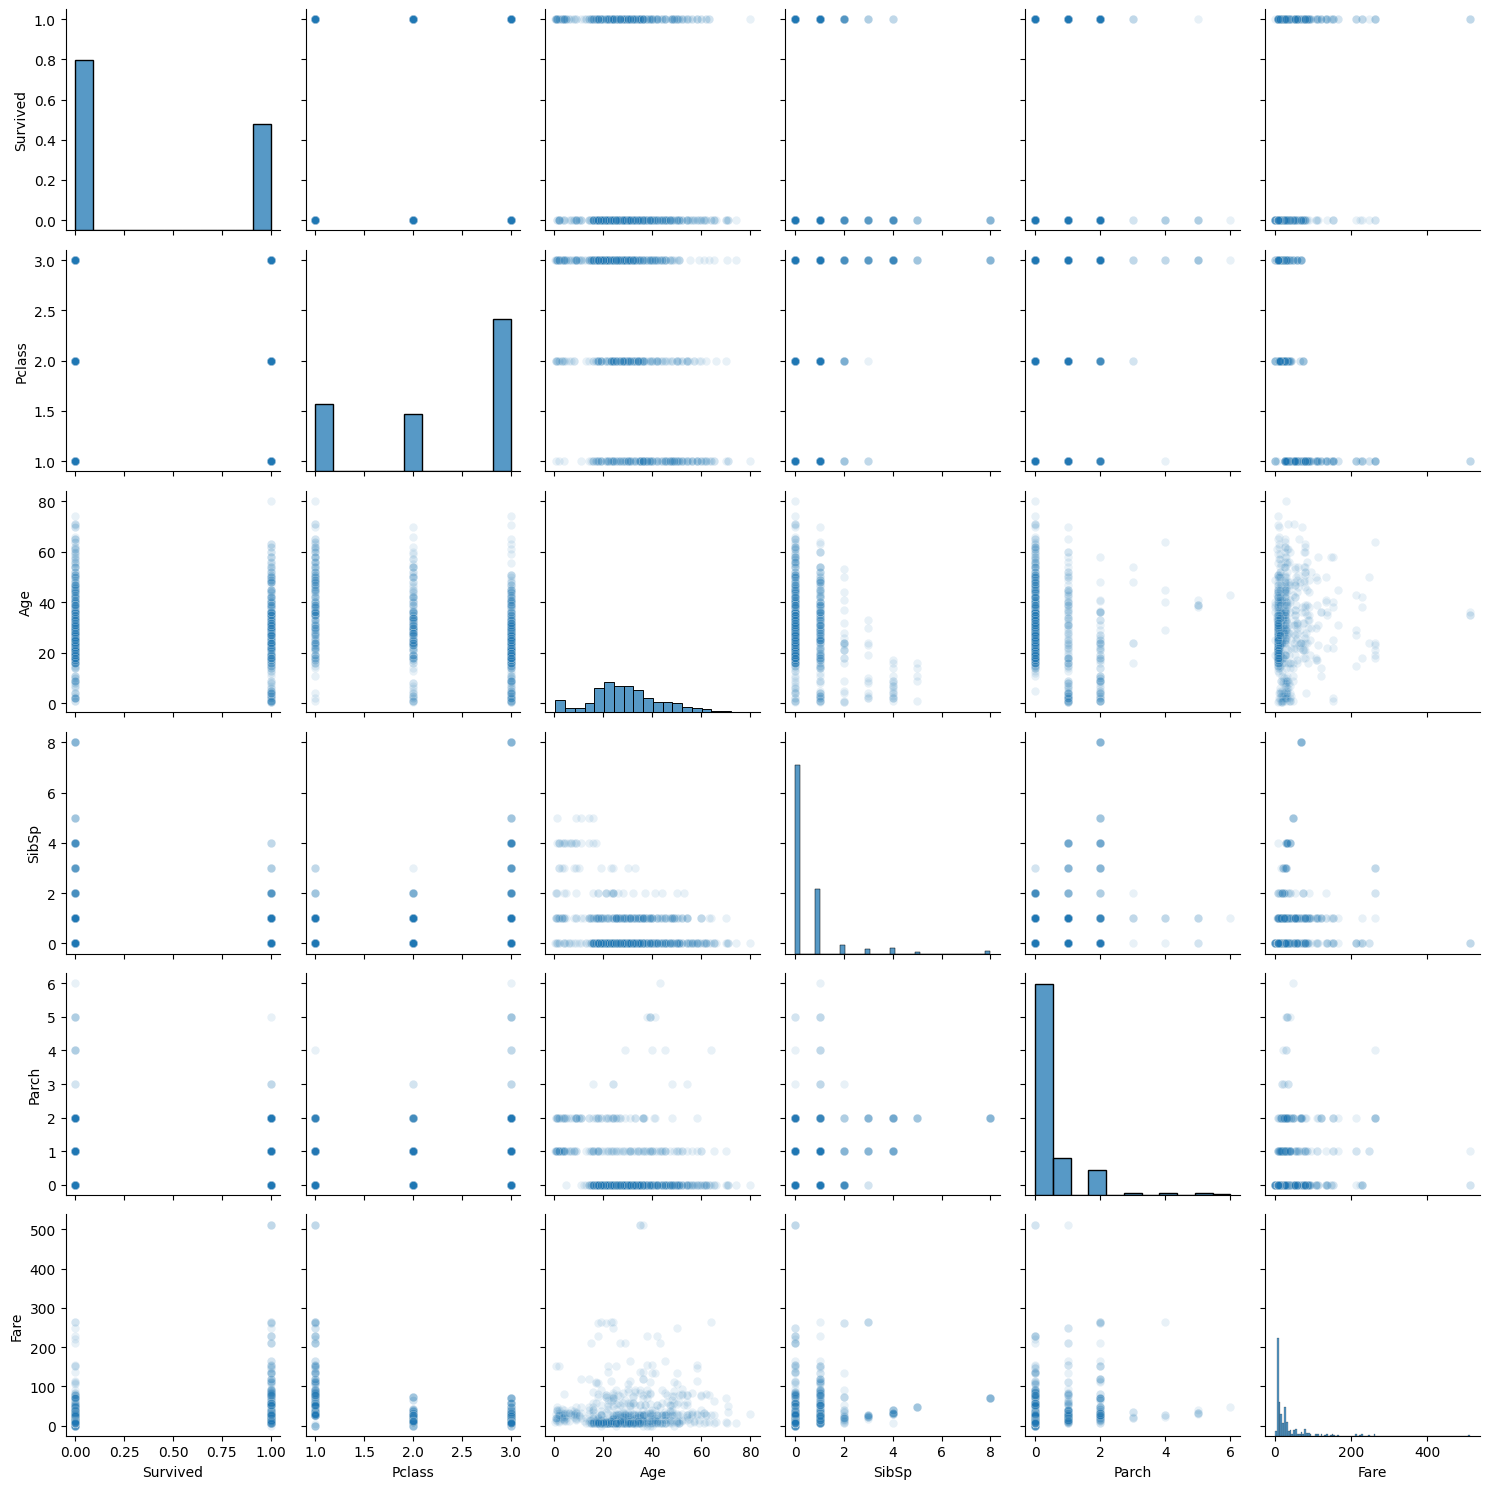

In [22]:
plot_scatter_matrix(df, exclude_cols=['PassengerId']);

## Trends

### NaN rate over time

In [317]:
date_col = 'datesold'
freq = 'Y'

# nans_per_perios = get_nans_per_period(df, date_col=date_col, freq=freq)
disp_nans_over_time(df, date_col, freq=freq)

,bedrooms,postcode,price,propertyType
2007,0.000000,0.000000,0.000000,0.000000
2008,0.000000,0.000000,0.000000,0.000000
2009,0.000000,0.000000,0.000000,0.000000
2010,0.000000,0.000000,0.000000,0.000000
2011,0.000000,0.000000,0.000000,0.000000
2012,0.000000,0.000000,0.000000,0.000000
2013,0.000000,0.000000,0.000000,0.000000
2014,0.000000,0.000000,0.000000,0.000000
2015,0.000000,0.000000,0.000000,0.000000
2016,0.000000,0.000000,0.000000,0.000000


In [318]:
disp_nans_over_time(
    df = pd.DataFrame({'a': [0, np.NaN, np.NaN], 'b': [0, 0, 0], 'c': [1, np.NaN, 2], 'date': pd.to_datetime(['2021', '2022', '2022'])}),
    date_col = 'date',
    freq='Y',
)


,a,c,b
2021,0.000000,0.000000,0.000000
2022,1.000000,0.500000,0.000000


### Values over time

#### Trends per column

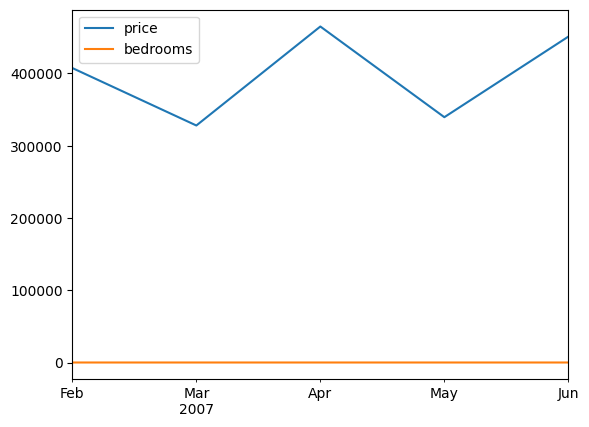

In [302]:
ax = plot_trends(
    df=df,
    date_col='datesold',
    trend_cols=['price','bedrooms'],
    freq='M',
    agg_func='median',
)

#### Trends per group (of single column)

house                                                         \
                0         1              2              3              4   
2012-09  415000.0       NaN  470250.000000  529166.417910  643846.774194   
2012-10       NaN       NaN  417000.000000  520819.698630  643240.833333   
2012-11       NaN       NaN  471885.571429  530983.190476  680224.358974   
2012-12       NaN       NaN  509750.000000  505861.111111  677641.129032   
2013-01       NaN  241000.0  431500.000000  491602.122449  603251.315789   
...           ...       ...            ...            ...            ...   
2007-02       NaN       NaN            NaN  290000.000000  525000.000000   
2007-03       NaN       NaN            NaN  319000.000000  380000.000000   
2007-04       NaN       NaN            NaN  399000.000000  997500.000000   
2007-05       NaN       NaN            NaN  339500.000000            NaN   
2007-06       NaN       NaN            NaN  345000.000000  710666.666667   

                       unit                                               \
                     5    0              1              2              3   
2012-09  995157.142857  NaN  345975.300000  443437.500000  513875.000000   
2012-10  879090.909091  NaN  355111.111111  390933.333333  518666.666667   
2012-11  864166.666667  NaN  385166.666667  423666.666667  464990.000000   
2012-12  791843.750000  NaN  400583.333333  487625.000000  527500.000000   
2013-01  817500.000000  NaN  347000.000000  422778.125000  755000.000000   
...                ...  ...            ...            ...            ...   
2007-02            NaN  NaN            NaN            NaN            NaN   
2007-03            NaN  NaN            NaN            NaN            NaN   
2007-04            NaN  NaN            NaN            NaN            NaN   
2007-05            NaN  NaN            NaN            NaN            NaN   
2007-06            NaN  NaN            NaN  300000.000000            NaN   

                        
                 4   5  
2012-09        NaN NaN  
2012-10        NaN NaN  
2012-11  1555000.0 NaN  
2012-12        NaN NaN  
2013-01        NaN NaN  
...            ...  ..  
2007-02        NaN NaN  
2007-03        NaN NaN  
2007-04        NaN NaN  
2007-05        NaN NaN  
2007-06        NaN NaN  

[150 rows x 12 columns]

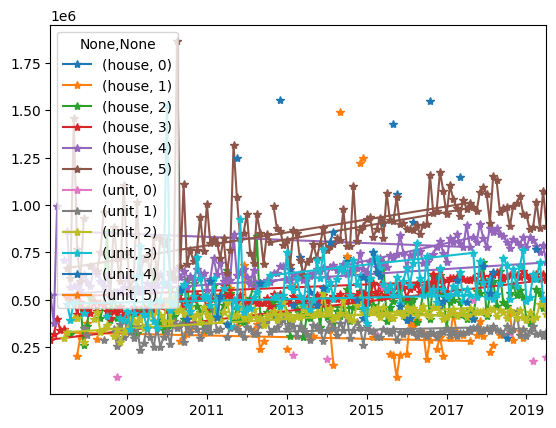

In [295]:
agged_per_group = agg_over_time_per_group(
    df=df,
    date_col='datesold',
    agg_col='price',
    groupby_cols=['propertyType','bedrooms'],
    freq='M',
    agg_func = 'mean',
)
display(agged_per_group)
agged_per_group.plot(style ='-*');

## Classes breakdown

# Preprocessing

## NaNs - fillna

### Mean imputation

In [23]:
COLS_IMPUTATIONS = {'Age': {
    VALUES_COL_KEY: 'Age',
    GROUPBY_COL_KEY: ['Survived', 'Sex']}
}
imputed = impute_by_group_mean(df, COLS_IMPUTATIONS)
imputed[df.Age.isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,31.618056,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,27.276022,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,28.847716,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,31.618056,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,28.847716,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,31.618056,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,25.046875,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,31.618056,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,31.618056,0,0,349217,7.8958,NaN,S


In [24]:
imputed[df.Age.isna()].groupby(['Survived', 'Sex'])['Age'].agg(['count', 'mean', 'nunique'])

count       mean  nunique
Survived Sex                              
0        female     17  25.046875        1
         male      108  31.618056        1
1        female     36  28.847716        1
         male       16  27.276022        1

In [25]:
imputed[df.Age.isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,31.618056,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,27.276022,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,28.847716,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,31.618056,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,28.847716,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,31.618056,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,25.046875,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,31.618056,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,31.618056,0,0,349217,7.8958,NaN,S


### KNN Imputation

In [26]:
imputer = KNNImputer(n_neighbors=5)
df_filled = imputer.fit_transform(df.select_dtypes('number'))
pd.DataFrame(df_filled[df.Age.isna()])

,0,1,2,3,4,5,6
0,6.0,0.0,3.0,26.0,0.0,0.0,8.4583
1,18.0,1.0,2.0,29.8,0.0,0.0,13.0000
2,20.0,1.0,3.0,27.6,0.0,0.0,7.2250
3,27.0,0.0,3.0,30.0,0.0,0.0,7.2250
4,29.0,1.0,3.0,30.0,0.0,0.0,7.8792
...,...,...,...,...,...,...,...
172,860.0,0.0,3.0,35.6,0.0,0.0,7.2292
173,864.0,0.0,3.0,41.0,8.0,2.0,69.5500
174,869.0,0.0,3.0,29.2,0.0,0.0,9.5000
175,879.0,0.0,3.0,21.8,0.0,0.0,7.8958


## Encoding

### One-hot

In [27]:
CAT_COL_ENCODING = {
    'Sex': {
        'drop_first': True
    }
}
one_hot_encode(df, CAT_COL_ENCODING)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,SibSp,Survived,Ticket,Sex,male
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,1,0,A/5 21171,male,True
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,PC 17599,female,False
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,0,1,STON/O2. 3101282,female,False
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,113803,female,False
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,0,0,373450,male,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.0,NaN,S,13.0000,"Montvila, Rev. Juozas",0,887,2,0,0,211536,male,True
887,19.0,B42,S,30.0000,"Graham, Miss. Margaret Edith",0,888,1,0,1,112053,female,False
888,NaN,NaN,S,23.4500,"Johnston, Miss. Catherine Helen ""Carrie""",2,889,3,1,0,W./C. 6607,female,False
889,26.0,C148,C,30.0000,"Behr, Mr. Karl Howell",0,890,1,0,1,111369,male,True


### Label Encoder

In [28]:
# ORIGINAL_POSTFIX = ''
        
label_encode(df, STR_ORDINAL_COLS_ORDERED)

2 missing values in Embarked are not label encoded.


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked_label_encoded
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,2.0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,2.0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,2.0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,0.0


### Target Encoding

In [29]:
df_target_encoded, col_encodings = target_encode_train(df, 'Survived', dict(Embarked=pd.Series.mode))
print(col_encodings)
df_target_encoded

{'Embarked': Embarked
C    1
Q    0
S    0
Name: Survived, dtype: int64}


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked_target_encoded
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0.0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,0.0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,0.0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,1.0
